# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
•	анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
•	контролировать добросовестность кассиров при продаже алкоголя.

<b>Инструкция по выполнению проекта:</b>

1.	Проведите исследовательский анализ набора фотографий.
2.	Подготовьте данные к обучению.
3.	Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Подключил необходимые библиотеки.

In [45]:
df = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(
        rescale = 1. / 255,
        )

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory='/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed=12345
        )

Found 7591 validated image filenames.


Загрузил данные, увидел, что в данных содержится 7591 фотография.

In [46]:
features, target = next(train_gen_flow)

Разбил выборку.

In [44]:
print(features.shape)
print(target.shape) 

(16, 150, 150, 3)
(16,)


32 - batch_size (Количество элементов выборки);  
150 - target_size (Высота изображения);  
150 - target_size (Ширина изображения);  
3 - количество каналов (Красный, зеленый, синий).

Проверил размер выборки.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Проверил информацию о количестве признаков в df.

In [41]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Проверил информацию о df.

In [42]:
print(df.isna().sum())

file_name    0
real_age     0
dtype: int64


Проверил количество пропусков, убедился в из отсутствии.

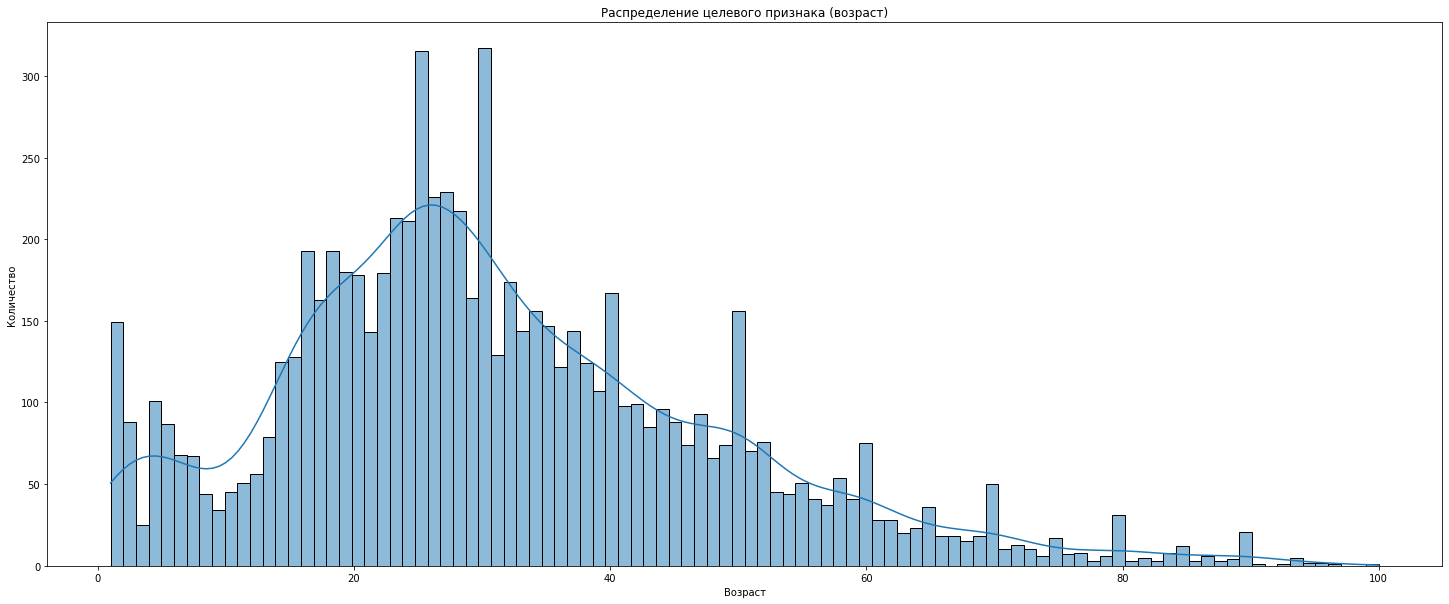

In [8]:
f, ax = plt.subplots(figsize=(25, 10))
sns.histplot(df.real_age, bins=100, alpha=0.5, kde=True)
plt.title('Распределение целевого признака (возраст)')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show();

Построил график распределения возраста в выборке.   
Наблюдаю, что возраст большей части записей находится в диапазоне от 18 - 40 лет.  
Средний показатель mean при вызове df.describe() выдает результат 31.2, что и подтверждается на графике.  
Могу предположить, что БД фотографий создавали люди и разметку сделали вручную, скорее всего данные округляли, из за этого такие всплески.

Возраст человека составляет: 50


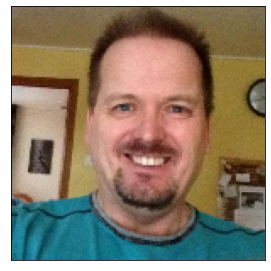

Возраст человека составляет: 41


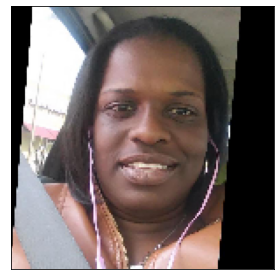

Возраст человека составляет: 46


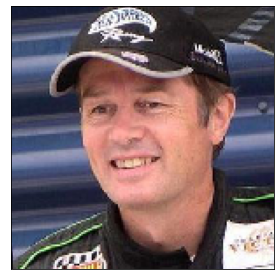

Возраст человека составляет: 85


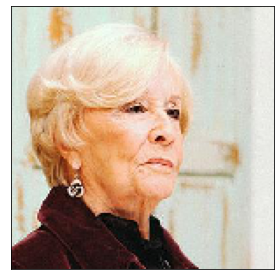

Возраст человека составляет: 14


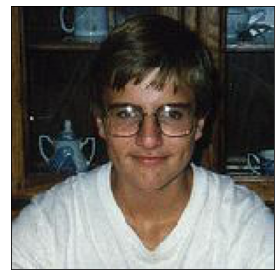

Возраст человека составляет: 40


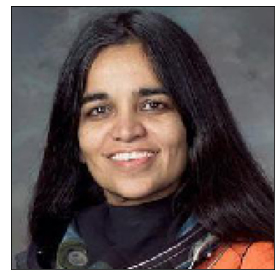

Возраст человека составляет: 14


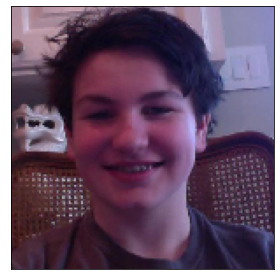

Возраст человека составляет: 53


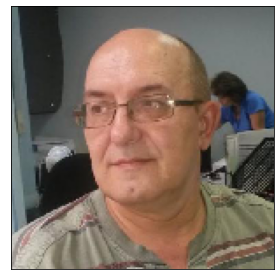

Возраст человека составляет: 4


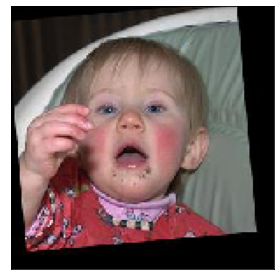

Возраст человека составляет: 32


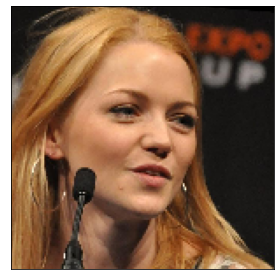

Возраст человека составляет: 14


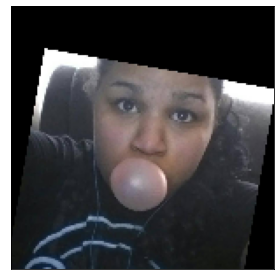

Возраст человека составляет: 23


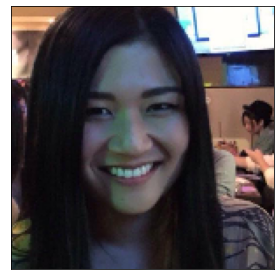

In [77]:
fig = plt.figure(figsize=(15,15))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    print(f'Возраст человека составляет: {target[i]}')
    plt.show()    

Напечатал 12 фотографий, делаю вывод, что из 12 фото есть только один ребенок и одна пожилая женщина, остальные 10 фотографий подходят под возрастную группу 18-40 лет.

- В базе данных находится 7591 фотография, я делаю вывод, что такая база не большая для точной оценки возрата.  
- Средний возраст большинства людей на фотографиях находится в диапазоне от 18-40 лет.  
- Так же на фотографиях присутствуют дети и пожилые люди, обучение модели на таких данных будет приводить к искажению результата.  
- Дополнительно хочу отметить, что на фотографиях присутствуют различные предметы, которые будут ухудшать результат. (Головной убор, жвачка, очки, искаженный фон).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

#################################

def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
                        rescale = 1. / 255,
                        )

    train_gen_flow = train_datagen.flow_from_dataframe(
                        dataframe = df,
                        directory = '/datasets/faces/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (150, 150),
                        batch_size = 32,
                        class_mode = 'raw',
                        subset = 'training',
                        seed = 12345
                        )

    return train_gen_flow

#################################

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
                        rescale = 1. / 255, 
                        )

    validation_gen_flow = valid_datagen.flow_from_dataframe(
                        dataframe = df,
                        directory = '/datasets/faces/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (150, 150),
                        batch_size = 32,
                        class_mode = 'raw',
                        subset = 'validation',
                        seed = 12345
                        )

    return validation_gen_flow
    
#################################

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights = 'imagenet',
                        include_top = False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation = 'relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])

    return model

#################################

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2
              )

    return model
    
#################################

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/5 190/190 - 128s - loss: 268.0187 - mae: 11.5632 - val_loss: 800.3179 - val_mae: 23.2091
Epoch 2/5 190/190 - 39s - loss: 63.3317 - mae: 6.0051 - val_loss: 674.1427 - val_mae: 20.7485
Epoch 3/5 190/190 - 41s - loss: 29.9173 - mae: 4.1982 - val_loss: 201.5736 - val_mae: 10.7181
Epoch 4/5 190/190 - 40s - loss: 18.9382 - mae: 3.4120 - val_loss: 108.9063 - val_mae: 7.8982
Epoch 5/5 190/190 - 42s - loss: 16.1630 - mae: 3.1345 - val_loss: 75.1797 - val_mae: 6.6174

48/48 - 9s - loss: 75.1797 - mae: 6.6174
Test MAE: 6.6174

```

## Анализ обученной модели

Выполняя проект я обучил модель ResNet50, которая показала значение метрики MAE = 6.6. Я считаю, что это хороший результат, для более лучшего предсказания стоит улучшить качество фотографий в датасете или провести эксперименты меняя параметры модели.

<b>MAE</b> это метрика, которая сообщает нам среднюю абсолютную разницу между прогнозируемыми значениями и фактическими значениями в наборе данных. В нашем случает это означет, что модель предсказывает возраст с отклонением 6.6 года от фактического значения, чем ниже показатель MAE тем лучше.


## Вывод

- Использованная архитектура ResNet50;
- batch_size = 32, optimizer = Adam(lr=0.0001), trainable = False, epochs=5
- MAE 6.6, переобучение не наблюдалось.